# Task Assignment - Rent Ready

## Ulugbek Zokirov

### Task
#### Из исходных данных соберите модель.

I was given three "csv" files with varying data

1. Table about 8 teams and their corresponding names
2. Table about the head count change in tables
3. Table about the works done by teams


In [1]:
## Teams
import pandas as pd
teams = pd.read_csv("raw_data/teams_table.csv")
teams

,TeamId,TeamName
0,1,A
1,2,D
2,3,O
3,4,P
4,5,J
5,6,R
6,7,S
7,8,U


In [2]:
## Head count changes in teams
team_changes = pd.read_csv("raw_data/teams_changing_table.csv")
team_changes.head()

,Date,TeamId,HeadCount
0,2021-01-01 00:00:00,NaN,1
1,2021-03-11 00:00:00,7.0,1
2,2021-04-17 00:00:00,7.0,1
3,2021-05-31 00:00:00,5.0,1
4,2021-06-14 00:00:00,2.0,1


In [3]:
## Work done by teams
works = pd.read_csv("raw_data/workitems_table.csv")
works.head()

,Work Item Id,Parent Work Item Id,TeamId,Created Date,Closed Date,State
0,6,NaN,NaN,2018-07-29 20:17:38,2018-07-30 16:09:11,Closed
1,7,63.0,NaN,2018-07-29 20:17:38,2021-08-22 12:25:59,Closed
2,13,NaN,NaN,2018-07-29 20:17:38,2018-07-30 18:06:44,Closed
3,15,NaN,NaN,2018-07-29 20:17:38,2018-07-30 18:08:56,Closed
4,18,NaN,NaN,2018-07-29 20:17:38,2018-07-30 02:18:02,Closed


## Issue with data

Tables about head count changes and work items have issues and data is not clean

1. Change in head count in teams starts from **2021-01-01**, however works table starts with **2018-07-29 20:17:38**, which means there is no data about how many people each team had between 2018, July and 2021
2. There is no initial head count of the company
3. Table of changes in head count has *None* values. So, 1 person joined in 2021-01-01, but to which team?
4. Works table also has *None* values. Great number of "Work Item Id" have no associated "Team Id"
5. “State” column in the works table has ambiguous values, such as “Resolved” which do not have "Closed date" associated with them

### Under these limitations, I made several assumptions

1. The initial value of head count was set to a variable N, which can be changed and it was assumed they were more or less evenly distributed across 8 teams
2. Changes in head count with no Team Id was set to "other"
3. After 2023-02-03 00:00:00, which is the last time head count changed, it was assumed no other people joined or left the teams

#### Due to these issues, I found it impossible to unify all three given tables into one model

## Task 1

### Рассчитайте и визуализируйте динамику ежемесячных затрат на каждую Команду. 

**Given:** Стоимость всех команд в мае 2023 года составила 500 USD в месяц. 

**Logic of the solution to the task**

1. Find the overall number of head count for May 2023
2. Divide 500 USD to overall head count to calculate the cost per person in May 2023
3. We will assume that cost per person was the same for previous months
4. Count the people for all the previous months by each team
5. Multiply cost per person to each team's head count
6. Visualize (Stacked Bar Chart) by months

In [4]:
### Calculate the overall change in head count from "teams_changing_table.csv"

import pandas as pd

## read two csv files
teams_change = pd.read_csv("raw_data/teams_changing_table.csv")
teams = pd.read_csv("raw_data/teams_table.csv")

## merge dfs into one to get Team Names for each team
merged_df = teams_change.merge(teams, how="left", on="TeamId")

## replace undefined teams with "other"
merged_df.fillna("other", inplace=True)

## overall head count for each team
df = merged_df.groupby("TeamName").sum("HeadCount")
print(df)

          HeadCount
TeamName           
D                 2
J                 4
P                 8
S                 4
other            13


In [5]:
## Initial head count
N = 0

## Head count in May 2023
head_count = df["HeadCount"].sum() + N
total_cost = 500

cost_per_person = round(total_cost / head_count, 2)

df["TeamCost"] = (df["HeadCount"] * cost_per_person)

## So in May 2023, each team had the following costs associated with them
print(df)

          HeadCount  TeamCost
TeamName                     
D                 2     32.26
J                 4     64.52
P                 8    129.04
S                 4     64.52
other            13    209.69


### Remarks
 
1. Most costs in May 2023 went to the "other" (undefined) team
2. Team P had the most people working in them (other than undefined team) and 26% of overall costs was expended on them
3. Initial head count is assumed 0. It is possible to give it some value, meaning there were some people working before 2021-01-01, when head count started to change. However, we will have to mark that initial value as "other" team, because we have no information about team structures before 2021. It will lead to "other" team having ever more share of the costs, which does not say much from analytical standpoint.

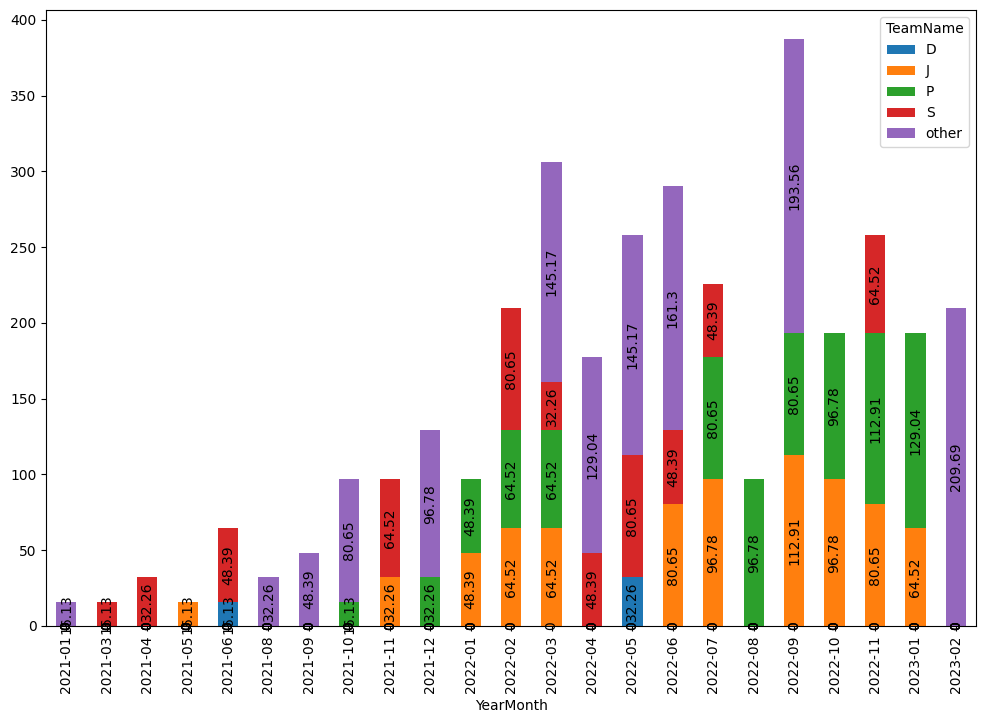

In [15]:
## Динамика ежемесячных затрат

## Extracr year and month from the date
merged_df['YearMonth'] = pd.to_datetime(merged_df['Date']).dt.strftime('%Y-%m')

## calculate cumulative sum of head count for each team per year and month
df = merged_df.groupby(["TeamName", "YearMonth"]).sum(["HeadCount"]).groupby(level=0).cumsum()

## calculate the team for each year month per team
df["TeamCost"] = df["HeadCount"] * cost_per_person

## fill the missing values and plot as stacked bar chart
df = df.pivot_table(values="TeamCost", index="YearMonth", columns="TeamName").fillna(0)
ax = df.plot.bar(stacked=True, figsize=(12, 8))
for c in ax.containers:
    ax.bar_label(c, label_type='center', rotation=90)
    
ax.legend(title='TeamName')
plt.show()

___

## Task 2

### Рассчитайте и визуализируйте динамику стоимости выполненных задач каждой Командой. (Дискретность - месяц) 

**Given:** Стоимость всех команд в мае 2023 года составила 500 USD в месяц.

**Logic of the solution to the task**
1. Find the overall number of hours spent for tasks for May 2023
2. Divide 500 USD to overall task hours to calculate the cost per hour in May 2023
3. We will assume that cost per hour was the same for previous months
4. Calculate total hour spent for task for all the previous months by each team
5. Multiply cost per hour to each team's total hours
6. Visualize (Stacked Bar Chart) by months

In [16]:
import pandas as pd

## read teams and works tables
teams = pd.read_csv("raw_data/teams_table.csv")
works = pd.read_csv("raw_data/workitems_table.csv")

## merge two tables
df_merged = works.merge(teams, how="left", on="TeamId").drop(["Parent Work Item Id"], axis=1)
## filter out only the "closed" tasks
df_merged = df_merged[df_merged["State"] == "Closed"]

## add duration of tasks in hours
df_merged["TaskDuration"] = df_merged["Closed Date"].astype('datetime64[ns]') - df_merged["Created Date"].astype('datetime64[ns]')

## extract Year-Month from the dates
df_merged["CreatedDate-YearMonth"] = pd.to_datetime(df_merged['Created Date']).dt.strftime('%Y-%m')
df_merged["ClosedDate-YearMonth"] = pd.to_datetime(df_merged['Closed Date']).dt.strftime('%Y-%m')

df_merged.head()

,Work Item Id,TeamId,Created Date,Closed Date,State,TeamName,TaskDuration,CreatedDate-YearMonth,ClosedDate-YearMonth
0,6,NaN,2018-07-29 20:17:38,2018-07-30 16:09:11,Closed,NaN,0 days 19:51:33,2018-07,2018-07
1,7,NaN,2018-07-29 20:17:38,2021-08-22 12:25:59,Closed,NaN,1119 days 16:08:21,2018-07,2021-08
2,13,NaN,2018-07-29 20:17:38,2018-07-30 18:06:44,Closed,NaN,0 days 21:49:06,2018-07,2018-07
3,15,NaN,2018-07-29 20:17:38,2018-07-30 18:08:56,Closed,NaN,0 days 21:51:18,2018-07,2018-07
4,18,NaN,2018-07-29 20:17:38,2018-07-30 02:18:02,Closed,NaN,0 days 06:00:24,2018-07,2018-07


### Issue
It appeared, from the duration of tasks, that some tasks took years to close. For instance, task 22 took 1666 days to get closed. 

- in a usual business case scenario, it happens because either the owner of the task forgot to close it on time, or it was left in the backlog without being worked on
- there is a possibility that task did really take 4.5 years to be completed, but we will assume this is not the case

### So
To fix this problem of super long task skewing the monthly figures, we will filter in the tasks that were opened and closed within the same months

In [8]:
df_merged = df_merged[df_merged["CreatedDate-YearMonth"] == df_merged["ClosedDate-YearMonth"]]
df_merged = df_merged.fillna("other")
df_merged.head(7)

,Work Item Id,TeamId,Created Date,Closed Date,State,TeamName,TaskDuration,CreatedDate-YearMonth,ClosedDate-YearMonth
0,6,other,2018-07-29 20:17:38,2018-07-30 16:09:11,Closed,other,0 days 19:51:33,2018-07,2018-07
2,13,other,2018-07-29 20:17:38,2018-07-30 18:06:44,Closed,other,0 days 21:49:06,2018-07,2018-07
3,15,other,2018-07-29 20:17:38,2018-07-30 18:08:56,Closed,other,0 days 21:51:18,2018-07,2018-07
4,18,other,2018-07-29 20:17:38,2018-07-30 02:18:02,Closed,other,0 days 06:00:24,2018-07,2018-07
6,25,other,2018-07-29 20:17:38,2018-07-30 03:06:23,Closed,other,0 days 06:48:45,2018-07,2018-07
7,27,other,2018-07-29 20:17:38,2018-07-30 18:14:33,Closed,other,0 days 21:56:55,2018-07,2018-07
9,51,other,2018-07-29 21:21:08,2018-07-30 21:25:55,Closed,other,1 days 00:04:47,2018-07,2018-07


### Task cost calculations for May

In [9]:
## Cost spent in May 2023
cost_may = 500

## extract the data for May for all teams
df_may = df_merged[df_merged["CreatedDate-YearMonth"] == "2023-05"]

## calculate the total hours spent on task
total_hours = round(df_may["TaskDuration"].sum() / pd.Timedelta('1 hour'))

## cost of one hour 
cost_per_hour = round(cost_may / total_hours, 2)

## group the data for may by Teams
df_may_grouped = df_may.groupby(["TeamName", "TeamId"]).agg({'Work Item Id': 'count', 'TaskDuration': 'sum'})
df_may_grouped.reset_index(inplace=True)

df_may_grouped["TaskTotalCost"] = (df_may_grouped["TaskDuration"]/pd.Timedelta('1 hour')) * cost_per_hour
df_may_grouped

,TeamName,TeamId,Work Item Id,TaskDuration,TaskTotalCost
0,A,1.0,1,0 days 16:46:44,0.671156
1,D,2.0,2,10 days 23:43:55,10.549278
2,J,5.0,16,44 days 22:24:32,43.136356
3,P,4.0,64,279 days 00:18:30,267.852333
4,S,7.0,60,83 days 23:25:17,80.616856
5,U,8.0,7,32 days 21:19:54,31.573267
6,other,other,7,15 days 13:00:59,14.920656


### Remarks

- in May, teams collectively spent 11233 hours on 157 different task
- cost per one hour of task was 0.04 USD
- half of overall cost was spent by Team P (Team ID = 4). They accumulated about 6700 hours of work on 64 different tasks with 267 USD spent on them
- team S (Team ID = 7) was much efficient in this matter. They also got 60 different tasks, but solved them only in 2015 hours, three times more efficient than Team P, hence three times less the cost, 80 USD

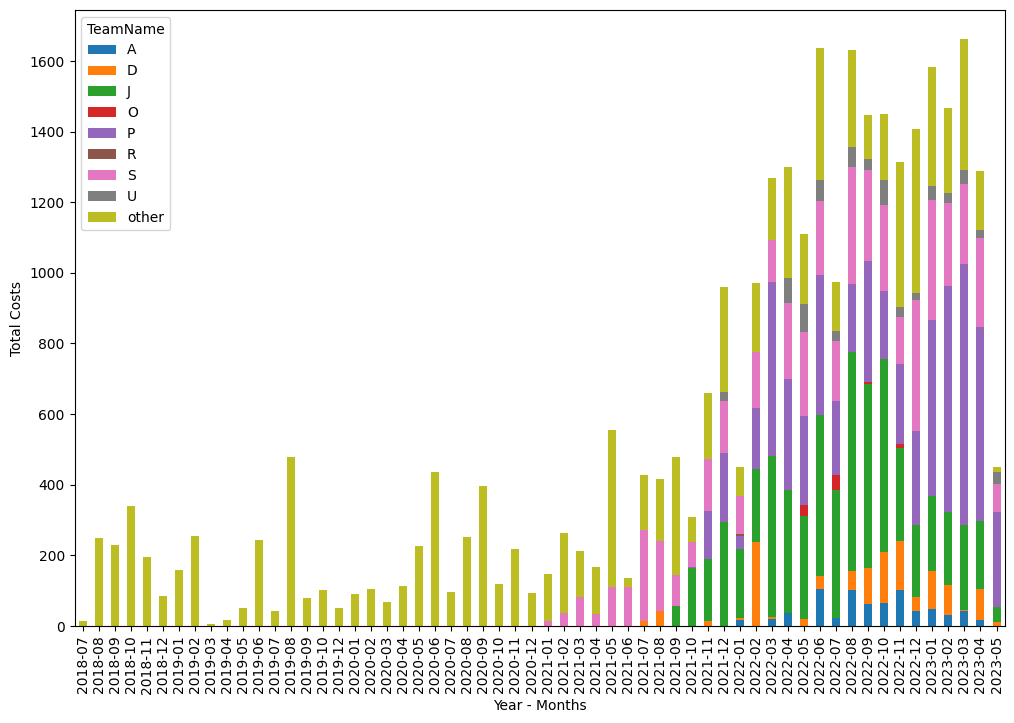

In [13]:
## динамикa стоимости выполненных задач
df_all_months = df_merged.groupby(['TeamName', 'CreatedDate-YearMonth']).agg({'Work Item Id': 'count', 'TaskDuration': 'sum'})
df_all_months['TaskCost'] = (df_all_months["TaskDuration"]/pd.Timedelta('1 hour')) * cost_per_hour


df_plot = df_all_months.pivot_table(values="TaskCost", index="CreatedDate-YearMonth", columns="TeamName").fillna(0)
ax = df_plot.plot.bar(stacked=True, figsize=(12, 8))
ax.set_xlabel("Year - Months")
ax.set_ylabel("Total Costs")

plt.show()

## Conclusion on the graph
1. Data prior 2021 was not in good quality. Team Ids were missing, hence there is not much to say about the trend prior 2021. This issue remains in all the years
2. In 2020, Team S gained momentum
3. From 2021 and onward we see Teams P and J were doing most of the task and most costs were associated with them
4. We see costs associated with Team J decreased in 2023, granular data shows that it was because they became efficient in solving the tasks. Volume of their task has not changed much. 

## Suggestions
1. It is critical to have full data. Tasks, if possible, should be retroactively assigned to Team Ids.
2. It is very important to close the tasks on time. If, the status of the task changes (from New to Failed, or Resolved, or to Draft), this change also should have timestamp associated with it. It would allow us to reduce the number of super long, forgotten tasks, have clearer division between teams. 
3. Team J should be commanded for their efficiency, while team J should optimize their workflow, as they have high costs associated with relatively low volume of tasks. 

___

## Task 3

### Спрогнозируйте объем задач, которые выполнит Команда (TeamId = 7) в мае, июне и июле 2023 года. 

**Given:** We will use the table from Task 2 for this exercise

**Logic of the solution to the task**

1. Extract the data for Team S (Team Id 7) for all years/months
2. We found moving average / exponential moving average to be the most suited method for this task, as:
    - teams are independent from one another (...несколькими независимыми командами)
    - we only have the task costs and task count as timeseries, no other data given for more sophisticated methods
    - general patterns show no seasonality

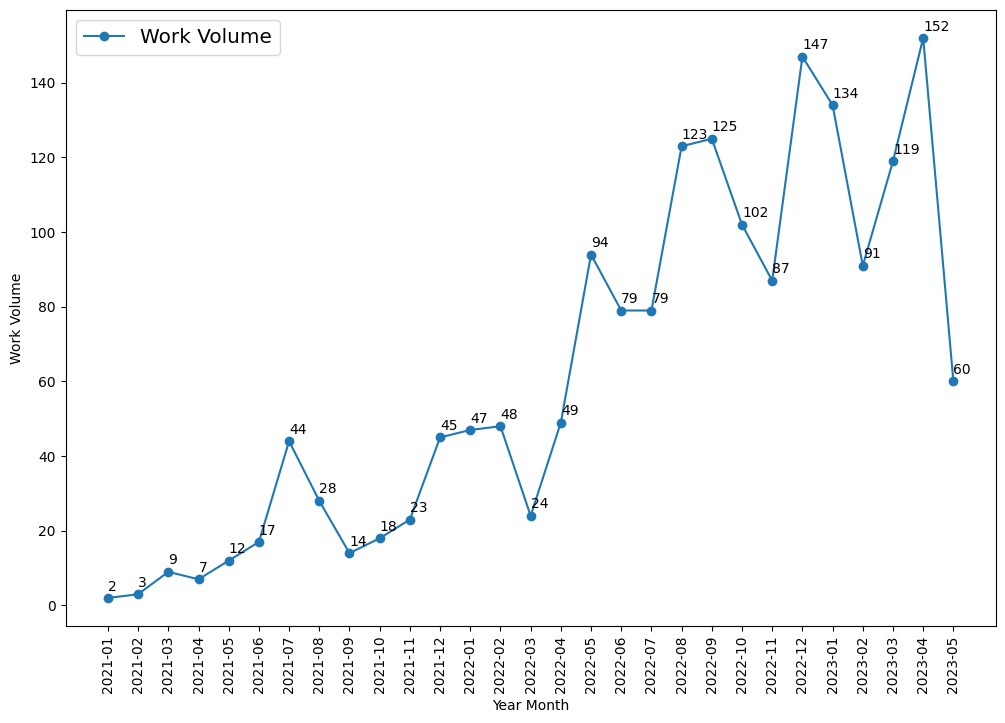

In [11]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

## extract the work count, task costs for Team S (Team Id 7)
tmp_df = df_all_months.reset_index()[['TeamName', 'CreatedDate-YearMonth', 'Work Item Id']]
df_team_s = tmp_df[tmp_df['TeamName'] == 'S'].reset_index().drop(['index', 'TeamName'], axis=1)

## plot the data
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
plt.plot(df_team_s['CreatedDate-YearMonth'], df_team_s['Work Item Id'], marker='o')
plt.xticks(rotation=90)
ax.set_xlabel('Year Month')
ax.set_ylabel('Work Volume')

for i,j in df_team_s['Work Item Id'].items():
    ax.annotate(str(j), xy=(i, j+2))
    
plt.legend(["Work Volume"], fontsize="x-large")
plt.show()

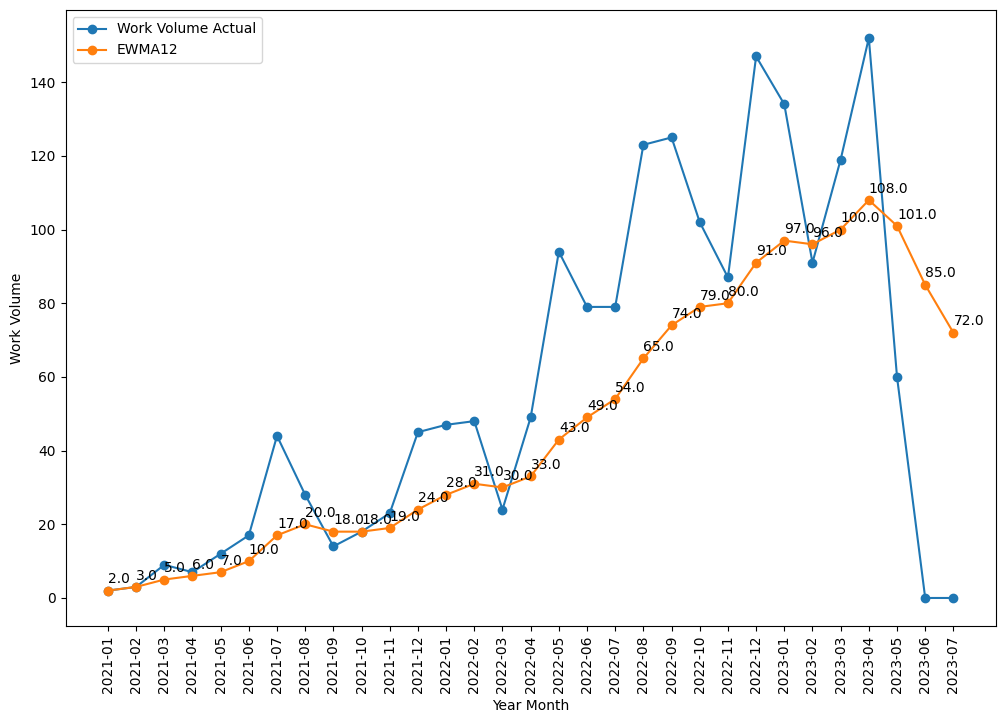

In [12]:
## add two new rows to the table
new_rows = {'CreatedDate-YearMonth': ['2023-06', '2023-07'], 'Work Item Id': [0, 0]}
new_df = pd.DataFrame(new_rows)

## concatenate two tables into final forecasting table
df_forecast = pd.concat([df_team_s, new_df])
df_forecast.rename(columns={'CreatedDate-YearMonth':'Year-Month', 'Work Item Id': 'Work Volume'}, inplace=True)

## add exponential moving average column
df_forecast['EWMA12'] = df_forecast['Work Volume'].ewm(span=12).mean().round()
df_forecast = df_forecast.reset_index().drop('index', axis=1)

## plot the data
fig = plt.figure(figsize=(12, 8))
ax = fig.add_subplot()
plt.plot(df_forecast['Year-Month'], df_forecast['Work Volume'], marker='o')
plt.plot(df_forecast['Year-Month'], df_forecast['EWMA12'], marker='o')

plt.xticks(rotation=90)
ax.set_xlabel('Year Month')
ax.set_ylabel('Work Volume')

for i,j in df_forecast['EWMA12'].items():
    ax.annotate(str(j), xy=(i, j+2))

plt.legend(['Work Volume Actual', 'EWMA12'])
plt.show()

## Conclusion on the graph
Different spans for exponential moving average was tried
- while lower values fit the historical data better, the could not capture the overall increasing trend
- hence it was chosen to set the span=12, which takes the last 12 months data and gives it more weight

## Based on this

Team S is expected to have the following work volumes:
- May: 101
- June: 85
- July: 72

### Possible improvements

1. If more data is available with Team Ids properly assigned and for longer period (at least 4-5 years of monthly data), it is possible to fit ARIMA (or SARIMA) models for better forecasting, with proper decomposition into trend, seasonal and residual figures
2. With more data, it is also possible to do regression analysis, correlations to find what exactly affects the volume of task in a given period